# Pipeline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

Here, please upload a zipped version of our repository. Because it is private, the git clone command will not work.

In [10]:
!rm -rf /content/acds-the-day-after-tomorrow-olga-main
!unzip -qqq /content/acds-the-day-after-tomorrow-olga-main.zip

In [11]:
!pip install -qqq pycm livelossplot
%pylab inline

import torch
#import olga

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torchvision import transforms
import torch.nn as nn

Populating the interactive namespace from numpy and matplotlib


In [12]:
# List of module names and file paths
module_info = [
    ("data_prep", '/content/acds-the-day-after-tomorrow-olga-main/olga/utils/data_prep.py'),
    ("wind_training_utils", '/content/acds-the-day-after-tomorrow-olga-main/olga/utils/wind_training_utils.py'),
    ("WindSpeed_model", "/content/acds-the-day-after-tomorrow-olga-main/olga/models/Final_WindSpeed.py"),
    ("convlstm", "/content/acds-the-day-after-tomorrow-olga-main/olga/models/convlstm.py"),
    ("WindSpeedARIMAModel", "/content/acds-the-day-after-tomorrow-olga-main/olga/models/arima.py")
    # Add more modules and file paths as needed
]

# Loop through the module_info list and import the modules
for module_name, file_path in module_info:
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)

# Now you can use the imported modules

CustomDataset = sys.modules["data_prep"].CustomDataset
StormImageDatasetLoader = sys.modules["data_prep"].StormImageDatasetLoader
ModelTrainer= sys.modules["wind_training_utils"].ModelTrainer
convlstm = sys.modules["convlstm"].ConvLSTM
WindSpeed_model = sys.modules["WindSpeed_model"].WindCNN
WindSpeedARIMA= sys.modules["WindSpeedARIMAModel"].WindSpeedARIMAModel



# Loading the data

In [13]:
from torch.utils.data import DataLoader, random_split
import torch
from torchvision import transforms


base_path = "/content/drive/MyDrive/storms_olga/tst"
train_csv_file = "tst_fulldata.csv"
test_csv_file = "tst_testdata (1).csv"


dataset_loader = StormImageDatasetLoader(base_path, train_csv_file, test_csv_file)

dataset_loader.load_dataset('train')
dataset_loader.load_dataset('test')

# Preparing the data

## Wind Speed

In [14]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_val_dataset = CustomDataset(dataset_loader.get_dataset('train'), transform=transform)
test_dataset = CustomDataset(dataset_loader.get_dataset('test'), transform=transform)

total_size = len(train_val_dataset)
train_size = int(total_size * 0.7)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Image Generation

In [15]:
transform_imgen = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((366, 366)),
    transforms.ToTensor(),
    transforms.Grayscale()])

train_val_dataset_imgen = CustomDataset(dataset_loader.get_dataset('train'), transform=transform_imgen)
test_dataset_imgen = CustomDataset(dataset_loader.get_dataset('test'), transform=transform_imgen)


## Image Generation with ConvLSTM

For image generation, we have decided to use the ConvLSTM architecture, as defined in this paper: https://proceedings.neurips.cc/paper_files/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf.

Our model produces 5x1x366x366 outputs by using the same shape of inputs. However, since we only care about the next three timesteps, we only save those.

As for the training of our model, you may find further information in the notebooks directory. Below is a screenshot of our training run. As you can see, the model converges after very few epochs.

![training run](media/training_run.png)

In [ ]:
from convlstm import ConvLSTM

image_model = ConvLSTM(input_dim=1,
                    hidden_dim=[64, 64, 1], # Define the number of channels for hidden states
                    kernel_size=(3, 3), # Kernel size for each ConvLSTMCell
                    num_layers=3, # Number of ConvLSTM layers
                    batch_first=True,
                    bias=True,
                    return_all_layers=False).to(device)

image_model.load_state_dict(torch.load('/content/drive/MyDrive/convlstm_MSE.pth'))

In [18]:
image_list = [test_dataset_imgen[-i][0] for i in range(1, 6)]
image_list = torch.stack(image_list).unsqueeze(0)

In [20]:
outputs, _ = image_model(image_list.to(device))
outputs = outputs[0]

In [21]:
outputs.shape

torch.Size([1, 5, 1, 366, 366])

### Saving our predictions

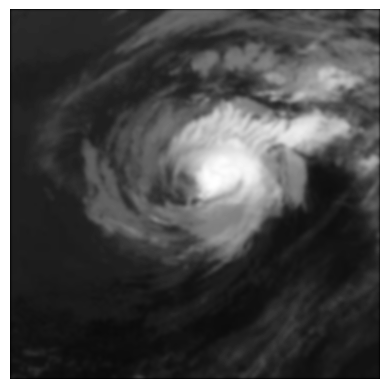

In [76]:
plt.imshow(outputs[0][0].detach().to("cpu").numpy().squeeze(), cmap="gray")
plt.axis('off')
plt.savefig("tst_252.jpg", bbox_inches='tight', pad_inches=0)

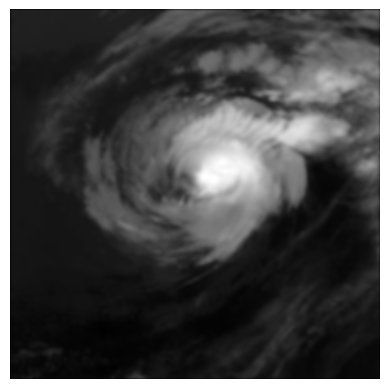

In [77]:
plt.imshow(outputs[0][1].detach().to("cpu").numpy().squeeze(), cmap="gray")
plt.axis('off')
plt.savefig("tst_253.jpg", bbox_inches='tight', pad_inches=0)

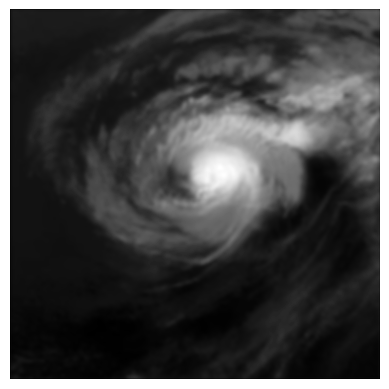

In [78]:
plt.imshow(outputs[0][2].detach().to("cpu").numpy().squeeze(), cmap="gray")
plt.axis('off')
plt.savefig("tst_254.jpg", bbox_inches='tight', pad_inches=0)

# Wind Speed Predictions. Training just on the surprise storm

For the `wind speed` prediction task we decided to combine to models to achieve the best predictions possible.

First, we use the WindCNN model to predict the firs 10 wind speed from the images we already have. Then, in order to not rely on the `image generation` model, we use a simple ARIMA model to predict the last 3 wind speed values.

## Wind Speed Prediction just the first 10 values with CNN

In [25]:
from WindSpeed_model import WindCNN

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WindCNN(num_classes=1).to(device)
n_epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
batch_size = 16

In [27]:
trainer = ModelTrainer(model, optimizer, criterion, device)

In [28]:
import torch

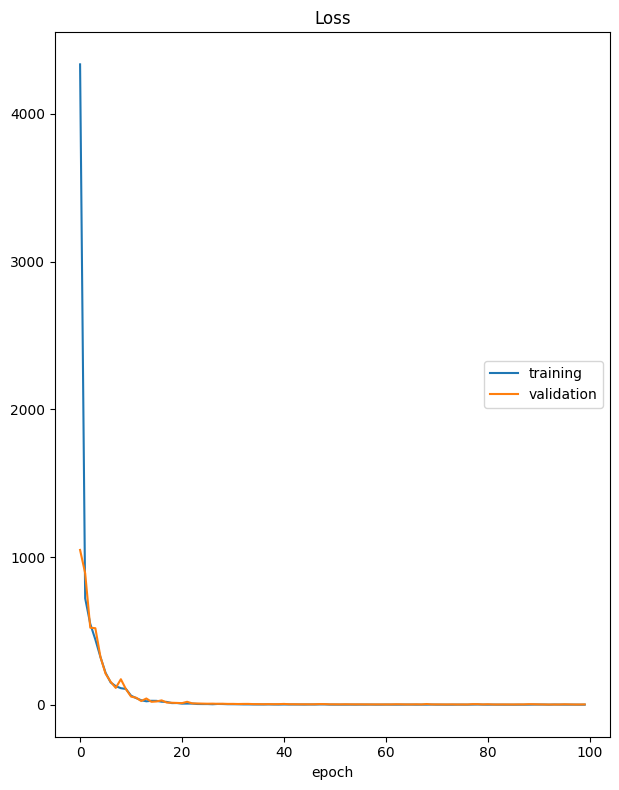

Loss
	training         	 (min:    0.284, max: 4335.636, cur:    0.580)
	validation       	 (min:    1.609, max: 1048.086, cur:    2.292)
Training completed.


In [29]:
trainer.train_model(train_dataset, val_dataset, n_epochs, lr, batch_size)

In [30]:
predictions, actuals, mse, mae = trainer.evaluate(test_loader)

These will be the first 10 predictions

In [31]:
predictions

[60.443935,
 60.02175,
 60.100407,
 59.374233,
 58.50455,
 57.789513,
 56.874252,
 55.708946,
 54.473858,
 54.488518]

## Wind speed prediction last 3 values with ARIMA

In [32]:
csv_path = "/content/tst_testdata (1).csv"
preds = pd.read_csv(csv_path)


preds['wind_speed'] = predictions


preds.to_csv(csv_path, index=False)

print("Updated CSV file with predictions saved.")

Updated CSV file with predictions saved.


In [33]:
df1 = pd.read_csv('tst_fulldata.csv')
df2 = pd.read_csv('tst_testdata (1).csv')

In [34]:
combined_df = pd.concat([df1, df2], ignore_index=True)

In [35]:
combined_df.to_csv('combined_file.csv', index=False)

In [36]:
from WindSpeedARIMAModel import WindSpeedARIMAModel


wind_speed_series = combined_df['wind_speed']


model_arima = WindSpeedARIMAModel(data=wind_speed_series)
model_arima.fit()

# Forecast the next 3 steps
forecast_steps = 3
forecast = model_arima.forecast(steps=forecast_steps)

print(f"Forecasted Wind Speed for the next {forecast_steps} steps:")
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecasted Wind Speed for the next 3 steps:
252    53.940133
253    53.283029
254    52.750285
Name: predicted_mean, dtype: float64


## Saving the csv file in the correct format

In [37]:
forecast_list = forecast.to_list()

# Combine both lists
combined_data = predictions + forecast_list

# Convert all values to integers
combined_data_int = [int(value) for value in combined_data]


combined_data_int

[60, 60, 60, 59, 58, 57, 56, 55, 54, 54, 53, 53, 52]

In [38]:
dataset_completed_df = pd.read_csv('/content/drive/MyDrive/storms_olga/tst/tst_data.csv')

In [39]:
dataset_completed_df

,index,image,wind_speed,relative_time
0,0,tst_000.jpg,31.0,0.0
1,1,tst_001.jpg,32.0,1800.0
2,2,tst_002.jpg,33.0,3601.0
3,3,tst_003.jpg,33.0,5400.0
4,4,tst_004.jpg,34.0,7200.0
...,...,...,...,...
250,250,tst_250.jpg,0.0,539999.0
251,251,tst_251.jpg,0.0,541799.0
252,252,tst_252.jpg,0.0,543599.0
253,253,tst_253.jpg,0.0,545399.0


In [40]:
new_df = dataset_completed_df.iloc[-13:].copy()

# Replace the "wind_speed" values in the new DataFrame with the updated values
new_df["wind_speed"] = combined_data_int

# Create a new DataFrame with only the "relative_time" and "wind_speed" columns
result_df = new_df[["relative_time", "wind_speed"]]

# Save the result DataFrame to a new CSV file
result_df.to_csv("updated_wind_speed.csv", index=False)

print("New CSV file 'updated_wind_speed.csv' created with the updated wind speed values.")

New CSV file 'updated_wind_speed.csv' created with the updated wind speed values.


In [41]:
new_df = new_df[['relative_time','wind_speed']]

In [42]:
new_df

,relative_time,wind_speed
242,522000.0,60
243,523800.0,60
244,525601.0,60
245,529199.0,59
246,530999.0,58
247,532799.0,57
248,534599.0,56
249,536398.0,55
250,539999.0,54
251,541799.0,54


In [43]:
new_df.to_csv("/content/drive/MyDrive/updated_wind_speed.csv", index=False)
